In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/random-images-for-face-emotion-recognition/surprise/images (68)_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202610.051_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203343.130_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202951.236_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202431.675_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202508.777_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T004452.516_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202620.534_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203753.431_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise

In [3]:
import os

# List what's available under /kaggle/input
for d in os.listdir("/kaggle/input"):
    print(d)


DATASET_DIR = "/kaggle/input/random-images-for-face-emotion-recognition"


print("Subfolders:", os.listdir(DATASET_DIR))

random-images-for-face-emotion-recognition
Subfolders: ['surprise', 'fear', 'sadness', 'neutrality', 'disgust', 'contempt', 'happiness', 'anger']


In [5]:
import tensorflow as tf
from tensorflow.keras import layers

base_dir = DATASET_DIR
img_size = (224, 224)
batch_size = 32

train_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    label_mode="categorical"  # one-hot
)

temp_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Split temp into val/test (15/15)
val_batches = tf.data.experimental.cardinality(temp_raw)
test_size   = val_batches // 2
test_raw    = temp_raw.take(test_size)
val_raw     = temp_raw.skip(test_size)

Found 5558 files belonging to 8 classes.
Using 3891 files for training.
Found 5558 files belonging to 8 classes.
Using 1667 files for validation.
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


In [6]:
# IMPORTANT: Use model-specific preprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# light augmentation on TRAIN ONLY
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
], name="augmentation")

# Map preprocess (and aug only on train)
train_ds = train_raw.map(lambda x,y: (augment(preprocess_input(x), training=True), y)) \
                    .cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds   = val_raw.map(lambda x,y: (preprocess_input(x), y)) \
                  .cache().prefetch(tf.data.AUTOTUNE)

test_ds  = test_raw.map(lambda x,y: (preprocess_input(x), y)) \
                  .cache().prefetch(tf.data.AUTOTUNE)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Pretrained backbone
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # 1) start frozen

model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(8, activation="softmax"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("mobilenetv2_baseline.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=callbacks)
print("Frozen backbone eval:", model.evaluate(test_ds, verbose=0))

Epoch 1/12


I0000 00:00:1756814788.980924     100 service.cc:148] XLA service 0x7b971c012f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756814788.982570     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756814788.982591     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756814789.907622     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/122 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1726 - loss: 2.6818

I0000 00:00:1756814795.209229     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 72s 143ms/step - accuracy: 0.2020 - loss: 2.3145 - val_accuracy: 0.3425 - val_loss: 1.9181 - learning_rate: 0.0010
Epoch 2/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3192 - loss: 1.8507 - val_accuracy: 0.3473 - val_loss: 1.7688 - learning_rate: 0.0010
Epoch 3/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3663 - loss: 1.6945 - val_accuracy: 0.3653 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 4/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3895 - loss: 1.6461 - val_accuracy: 0.3964 - val_loss: 1.7562 - learning_rate: 0.0010
Epoch 5/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4155 - loss: 1.5771 - val_accuracy: 0.4072 - val_loss: 1.6977 - learning_rate: 0.0010
Epoch 6/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4507 - loss: 1.5092 - val_accuracy: 0.3916 - val_loss: 1.7026 - learning_rate: 0.0010
Epoch 7/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4434 - loss: 1.5211 - va

In [16]:
# Fine tune the model now 
# unfreeze the top N layers

# Helper to unfreeze the last N layers of the backbone
def unfreeze_top_layers(base_model, n_top_layers=40):
    base_model.trainable = True
    for layer in base_model.layers[:-n_top_layers]:
        layer.trainable = False
    print(f"Total layers: {len(base_model.layers)} | Unfrozen top: {n_top_layers}")

unfreeze_top_layers(base, n_top_layers=45)  # try 20–60; adjust based on results

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # lower LR for fine-tune
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)
print("Fine-tuned eval:", model.evaluate(test_ds, verbose=0))

Total layers: 154 | Unfrozen top: 45
Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.9992 - loss: 9.8378e-04 - val_accuracy: 0.4407 - val_loss: 3.6177 - learning_rate: 1.0000e-04
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 1.3818e-04 - val_accuracy: 0.4443 - val_loss: 3.7608 - learning_rate: 1.0000e-04
Epoch 3/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 3.3451e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9999 - loss: 3.5862e-04 - val_accuracy: 0.4144 - val_loss: 3.9667 - learning_rate: 1.0000e-04
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.4240 - val_loss: 3.8817 - learning_rate: 2.0000e-05
Epoch 5/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.8582e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-0

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Classification report
y_true = np.concatenate([y.numpy().argmax(axis=1) for _, y in test_ds])
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Test accuracy: 0.4435 | Test loss: 3.8148
              precision    recall  f1-score   support

       anger     0.4714    0.2340    0.3128       141
    contempt     0.0870    0.0556    0.0678        36
     disgust     0.2188    0.1296    0.1628        54
        fear     0.3210    0.2826    0.3006        92
   happiness     0.6292    0.7626    0.6895       198
  neutrality     0.3667    0.2619    0.3056        84
     sadness     0.3505    0.3269    0.3383       104
    surprise     0.4105    0.7642    0.5341       123

    accuracy                         0.4435       832
   macro avg     0.3569    0.3522    0.3389       832
weighted avg     0.4246    0.4435    0.4159       832



In [18]:
# fine tuning. keep batch norm layers frozen 

def unfreeze_top_layers_keep_bn(base_model, n_top_layers=40):
    base_model.trainable = True
    for layer in base_model.layers[:-n_top_layers]:
        layer.trainable = False
    # keep BatchNorms frozen
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    print(f"Total layers: {len(base_model.layers)} | Unfrozen top: {n_top_layers}")

unfreeze_top_layers_keep_bn(base, n_top_layers=20)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)
print("Fine-tuned eval:", model.evaluate(test_ds, verbose=0))

Total layers: 154 | Unfrozen top: 40
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9677 - loss: 0.0948 - val_accuracy: 0.4216 - val_loss: 2.9411 - learning_rate: 1.0000e-04
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9874 - loss: 0.0452 - val_accuracy: 0.4395 - val_loss: 3.7738 - learning_rate: 1.0000e-04
Epoch 3/10
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9813 - loss: 0.0495
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9812 - loss: 0.0498 - val_accuracy: 0.4048 - val_loss: 3.8115 - learning_rate: 1.0000e-04
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9930 - loss: 0.0184 - val_accuracy: 0.4539 - val_loss: 3.1215 - learning_rate: 2.0000e-05
Epoch 5/10
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
122/122 ━━━━━━━━━

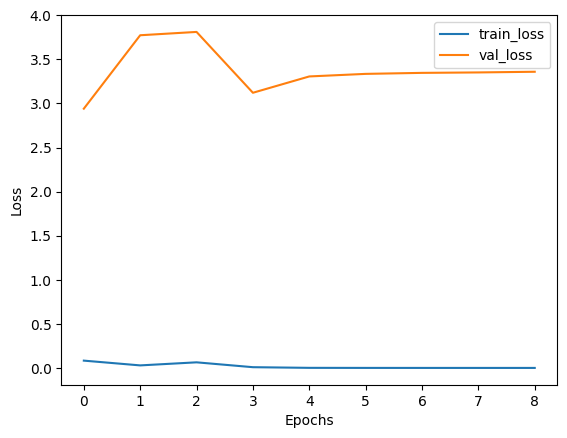

In [19]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history["loss"], label="train_loss")
plt.plot(history_ft.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Pretrained backbone
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # 1) start frozen

# Add a custom classifier head with extra dropout
model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),   # extra dense layer
    layers.Dropout(0.5),                    # stronger dropout after dense
    layers.Dense(64, activation="relu"),    # optional second dense
    layers.Dropout(0.3),                    # lighter dropout
    layers.Dense(8, activation="softmax"),  # final classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("mobilenetv2_baseline.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=callbacks)
print("Frozen backbone eval:", model.evaluate(test_ds, verbose=0))

Epoch 1/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.1989 - loss: 2.1701 - val_accuracy: 0.3090 - val_loss: 1.8891 - learning_rate: 0.0010
Epoch 2/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2660 - loss: 1.9389 - val_accuracy: 0.3090 - val_loss: 1.8521 - learning_rate: 0.0010
Epoch 3/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.2612 - loss: 1.8814 - val_accuracy: 0.3449 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 4/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3002 - loss: 1.8106 - val_accuracy: 0.3749 - val_loss: 1.7379 - learning_rate: 0.0010
Epoch 5/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3225 - loss: 1.7671 - val_accuracy: 0.3293 - val_loss: 1.7563 - learning_rate: 0.0010
Epoch 6/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3271 - loss: 1.7542 - val_accuracy: 0.3749 - val_loss: 1.6821 - learning_rate: 0.0010
Epoch 7/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3428 - loss: 

In [23]:
# fine tuning. keep batch norm layers frozen 

def unfreeze_top_layers_keep_bn(base_model, n_top_layers=40):
    base_model.trainable = True
    for layer in base_model.layers[:-n_top_layers]:
        layer.trainable = False
    # keep BatchNorms frozen
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    print(f"Total layers: {len(base_model.layers)} | Unfrozen top: {n_top_layers}")

unfreeze_top_layers_keep_bn(base, n_top_layers=20)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)
print("Fine-tuned eval:", model.evaluate(test_ds, verbose=0))

Total layers: 154 | Unfrozen top: 20
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accuracy: 0.3890 - loss: 1.5780 - val_accuracy: 0.3832 - val_loss: 1.6299 - learning_rate: 1.0000e-05
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3960 - loss: 1.5587 - val_accuracy: 0.4012 - val_loss: 1.6178 - learning_rate: 1.0000e-05
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3976 - loss: 1.5537 - val_accuracy: 0.4012 - val_loss: 1.6072 - learning_rate: 1.0000e-05
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4014 - loss: 1.5504 - val_accuracy: 0.4024 - val_loss: 1.6052 - learning_rate: 1.0000e-05
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4270 - loss: 1.5123 - val_accuracy: 0.4060 - val_loss: 1.6040 - learning_rate: 1.0000e-05
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4071 - loss: 1.4959 - val_accuracy: 0.4096 - val_loss: 1.6006 - learning_rate: 1.0000e-05
Epoch 7/50
122/122 

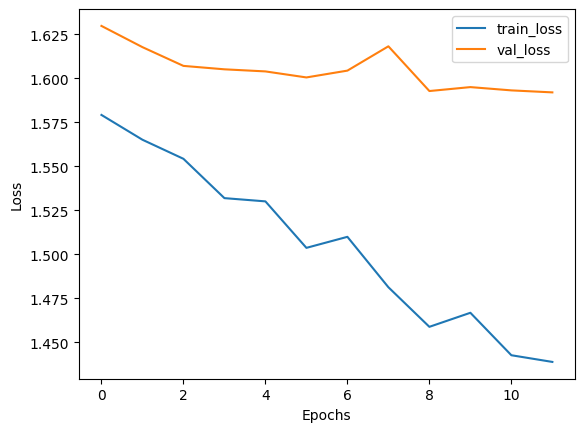

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history["loss"], label="train_loss")
plt.plot(history_ft.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# changing the data augmentation parameters
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# light augmentation on TRAIN ONLY
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
], name="augmentation")

# Map preprocess (and aug only on train)
train_ds = train_raw.map(lambda x,y: (augment(preprocess_input(x), training=True), y)) \
                    .cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds   = val_raw.map(lambda x,y: (preprocess_input(x), y)) \
                  .cache().prefetch(tf.data.AUTOTUNE)

test_ds  = test_raw.map(lambda x,y: (preprocess_input(x), y)) \
                  .cache().prefetch(tf.data.AUTOTUNE)


In [26]:


# Pretrained backbone
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # 1) start frozen

# Add a custom classifier head with extra dropout
model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),   # extra dense layer
    layers.Dropout(0.5),                    # stronger dropout after dense
    layers.Dense(64, activation="relu"),    # optional second dense
    layers.Dropout(0.3),                    # lighter dropout
    layers.Dense(8, activation="softmax"),  # final classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("mobilenetv2_baseline.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=callbacks)
print("Frozen backbone eval:", model.evaluate(test_ds, verbose=0))

Epoch 1/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - accuracy: 0.1795 - loss: 2.1889 - val_accuracy: 0.2886 - val_loss: 1.9432 - learning_rate: 0.0010
Epoch 2/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.2414 - loss: 1.9568 - val_accuracy: 0.3018 - val_loss: 1.8667 - learning_rate: 0.0010
Epoch 3/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.2522 - loss: 1.9048 - val_accuracy: 0.3293 - val_loss: 1.8432 - learning_rate: 0.0010
Epoch 4/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.2787 - loss: 1.8506 - val_accuracy: 0.3593 - val_loss: 1.7737 - learning_rate: 0.0010
Epoch 5/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3069 - loss: 1.7970 - val_accuracy: 0.3569 - val_loss: 1.7420 - learning_rate: 0.0010
Epoch 6/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3088 - loss: 1.7777 - val_accuracy: 0.3641 - val_loss: 1.7111 - learning_rate: 0.0010
Epoch 7/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3320 - loss: 

In [27]:
# fine tuning. keep batch norm layers frozen 

def unfreeze_top_layers_keep_bn(base_model, n_top_layers=40):
    base_model.trainable = True
    for layer in base_model.layers[:-n_top_layers]:
        layer.trainable = False
    # keep BatchNorms frozen
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    print(f"Total layers: {len(base_model.layers)} | Unfrozen top: {n_top_layers}")

unfreeze_top_layers_keep_bn(base, n_top_layers=10)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)
print("Fine-tuned eval:", model.evaluate(test_ds, verbose=0))

Total layers: 154 | Unfrozen top: 10
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.3625 - loss: 1.6364 - val_accuracy: 0.3784 - val_loss: 1.7158 - learning_rate: 1.0000e-05
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3860 - loss: 1.6282 - val_accuracy: 0.3772 - val_loss: 1.7034 - learning_rate: 1.0000e-05
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3869 - loss: 1.6008 - val_accuracy: 0.3868 - val_loss: 1.6845 - learning_rate: 1.0000e-05
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3840 - loss: 1.5953 - val_accuracy: 0.3880 - val_loss: 1.7051 - learning_rate: 1.0000e-05
Epoch 5/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3985 - loss: 1.5628
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3985 - loss: 1.5627 - val_accuracy: 0.3749 - val_loss: 1.6896 - learning_rate: 1.0000e-05
Epoch 6/50
122/122 ━━━━

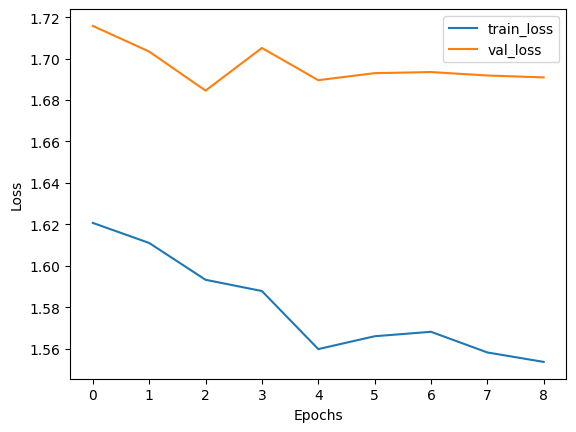

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history["loss"], label="train_loss")
plt.plot(history_ft.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()